# Introduction:
Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life. Let's filter out the hate from our platforms one comment at a time.

# Objective:
To create an EDA/ feature-engineering starter notebook for toxic comment classification.

# Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

toxic
severe_toxic
obscene
threat
insult
identity_hate
The tagging was done via crowdsourcing which means that the dataset was rated by different people and the tagging might not be 100% accurate too. 

The <a href="https://arxiv.org/pdf/1610.08914.pdf">source paper</a> also contains more interesting details about the dataset creation.

# Disclaimer:

    
#### <span style="color:red">*This notebook contains words or language that are considered profane, vulgar, or offensive by some readers. Reader discretion is adviced*</span>

In [2]:
#import required packages
#basics
import pandas as pd 
import numpy as np
import sys, os, re, csv, codecs

#misc
import gc
import time
import warnings
import pickle

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
import matplotlib as mpl
import pyLDAvis.gensim

# nlp
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
import re    
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import nltk


# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from gensim.models.word2vec import Word2Vec
from sklearn import preprocessing,metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model,svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import average_precision_score, classification_report,confusion_matrix
from scipy.stats import skew
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from nltk import word_tokenize
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import string
from collections import defaultdict
import nltk
import pandas as pdz
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Settings

color = sns.color_palette()
sns.set_style("dark")
mpl.rcParams["figure.dpi"] = 100

eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=ToktokTokenizer()

/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv("train.csv").fillna(' ')

train = data.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = data[~data['id'].isin(list(train['id']))].reset_index(drop=True)

# Exploratory Data Analysis

In [4]:
# a quick look at the data
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
127647,b602a40d876506b4,Pls Help\n\n I was upload a pic - File...,0,0,0,0,0,0
127648,1a52bce3b5d46ed9,"""Mark, I am sorry for your desperation (I'll r...",0,0,0,0,0,0
127649,ab25b8ec7b86d6d8,"""\n\n Size: Edit Request \nWould the author pl...",0,0,0,0,0,0
127650,dab37a9958761d52,Userfy request \n\nHi - wondering if you'd be ...,0,0,0,0,0,0
127651,af291e6ef1eb8e04,I ask that you take this information into acco...,0,0,0,0,0,0
127652,0ce45a8fbb4a2c7e,"NUISANCE Hello there, just being a bit of a nu...",0,0,0,0,0,0
127653,5ac907a4723e389c,protect against skeptic-vandals\n\nLike DreamG...,0,0,0,0,0,0
127654,40e179526311521d,How about leaving the dishonourable epithet up...,1,0,1,0,0,0
127655,93898a03a1577f69,Looks like the criticism content has been remo...,0,0,0,0,0,0
127656,bcc6a4fc5f123163,delete this pagedelete this pagedelete this pa...,0,0,0,0,0,0


In [5]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 127657 : 31914
perc   : 80    : 20


There is a 30:70 train: test split and the test set might change in the future too.

Let's take a look at the class imbalance in the train set.

#### Class Imbalance:

In [6]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  127657
Total clean comments =  114705
Total tags = 27983


In [7]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
filling NA with "unknown"


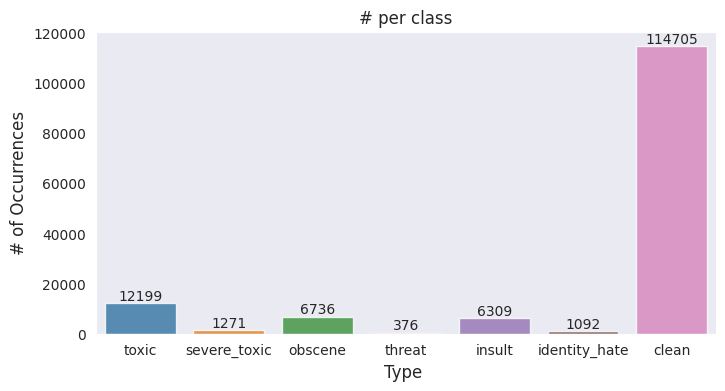

In [8]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

- The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
- There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!
- This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

#### Multi-tagging:

Let's check how many comments have multiple tags.

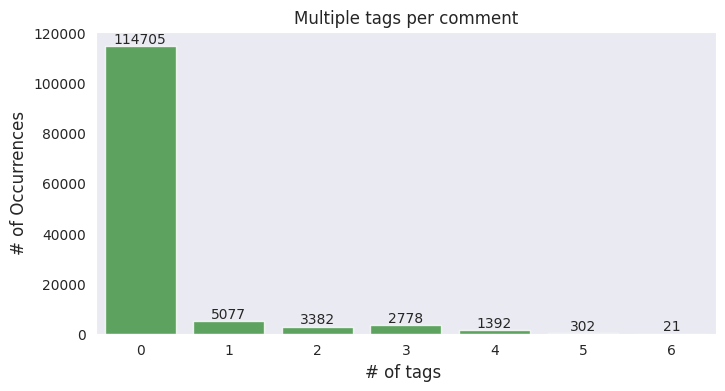

In [9]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<AxesSubplot:>

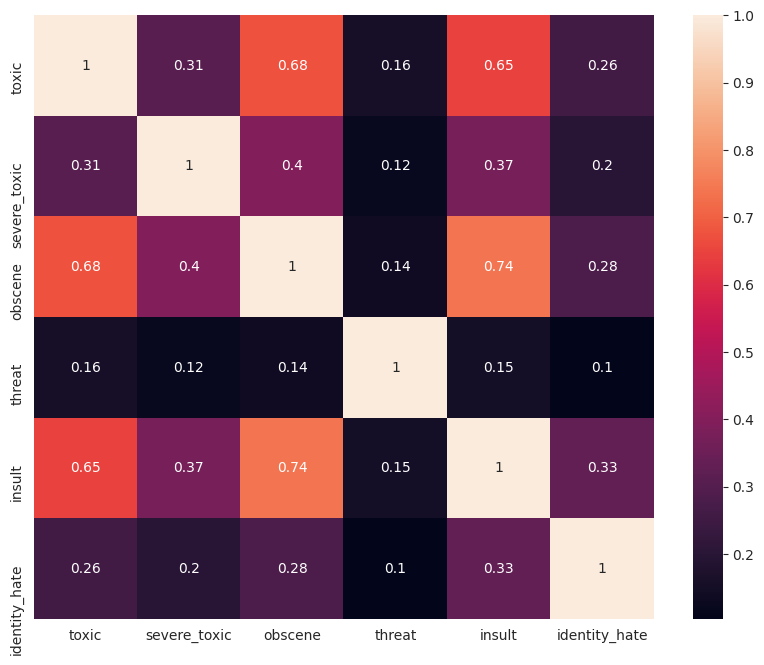

In [10]:
temp_df=train.iloc[:,2:-1]


corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

- Confusion matrix/Crosstab
- Cramer's V Statistic
- Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

In [11]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='red'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1: 
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else: 
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [12]:
#Crosstab

main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

- A Severe toxic comment is always toxic
- Other classes seem to be a subset of toxic barring a few exceptions

In [13]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [14]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)


Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             115458     0
1              10928  1271
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30836711898445257


#### Example Comments:

In [15]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
Hello 

go fuck yourself, kid.  Adults are talking.


In [16]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
#print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
Oh fuck you, you partisan asshole. You never step forward unless it's someone on the opposite side from you doing it. You sit there silently while people defending Moore and bashing everything that's not a Leftist view snark, sneer, and throw around off-topic bullshit and insults, and then as soon as someone who's NOT on your side responds in kind, suddenly it's warnings and quoting NPA and all that crap. You're a pathetic, useless excuse for a moderator, and I spit in your worthless, virtual face. You can ban me if you like, but all it will do is prove the partisanship and hypocrisy of the wikipedia administration staff. Dickhead. -


In [17]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
Hello, you turd. 

Firśt, I aṃ ģoinģ ţo ţie ŷou uṗ and keeṗ ŷou çonśçiouś durinģ ţhe folloŵinģ ṗroçeśś ţhrough ţhe uśe of aṃṃonia. Nexţ, I ŵill ṃuţilaţe ŷour ģeniţalś and forçe ŷou ţo eaţ ţheṃ. Then I ŵill çuţ off biţś of ŷour śkin and ṃake a ģlove ouţ of ţhe śkin from ŷour hand. I ŵill ţhen çuţ oṗen ŷour ģuţ and ṗull ouţ ŷour çolon. I ŵill uśe ŷour çolon for ṃaśţurbaţion, and ŵhen I am done I ŵill śhove iţ down ŷour ţhroaţ. Finally, I ŵill diśṗośe of ŷour body by deṗosiţinģ iţ in a duṃṗ ŵhere iţ belonģś.


In [18]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
Suck my dikkkkk ==
Suck my dikkkkk Gogo Gogo giving blowjobs on demand


In [19]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
"

 Niggers 
We need more information in this section regarding the widespread usage of the ""Jew's Harp"" by Nigger Slaves in the Antebellum south,"


That was a whole lot of toxicity. Some weird observations:

- Some of the comments are extremely and mere copy paste of the same thing
- Comments can still contain IP addresses(eg:62.158.73.165), usernames(eg:ARKJEDI10) and some mystery numbers(i assume is article-IDs)
- Point 2 can cause huge overfitting.



#### Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes

In [20]:
stopword=set(STOPWORDS)

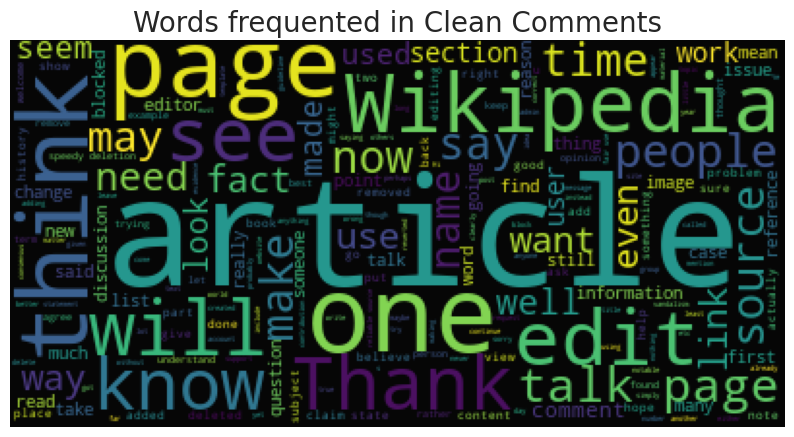

In [21]:
#clean comments

#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

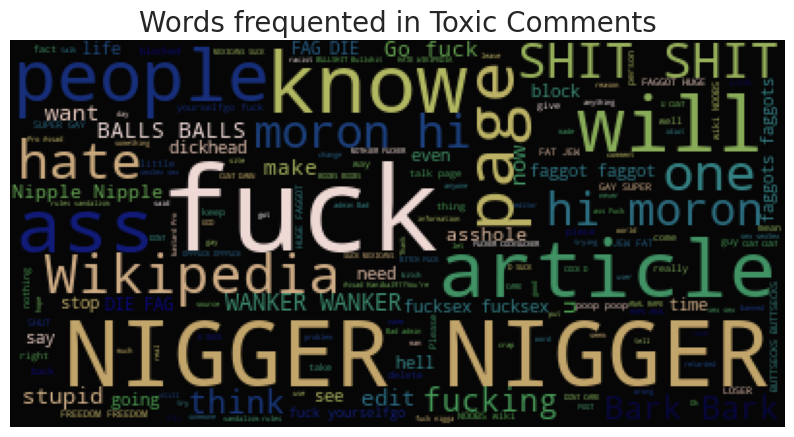

In [22]:
#wordcloud for toxic comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)
plt.show()

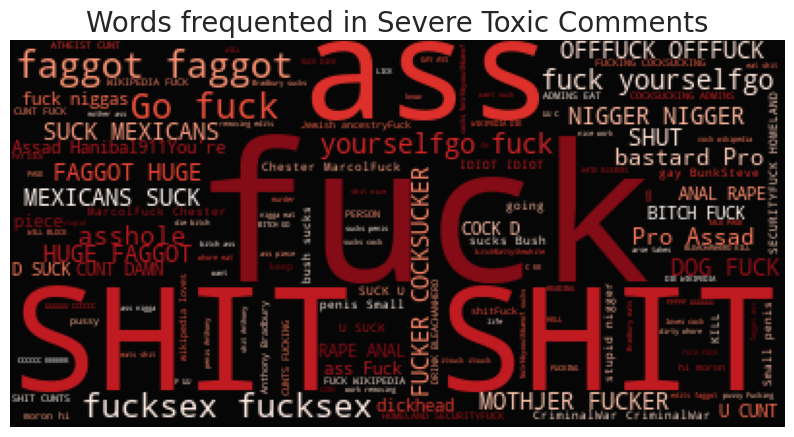

In [23]:
#Severely toxic comments
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
plt.show()

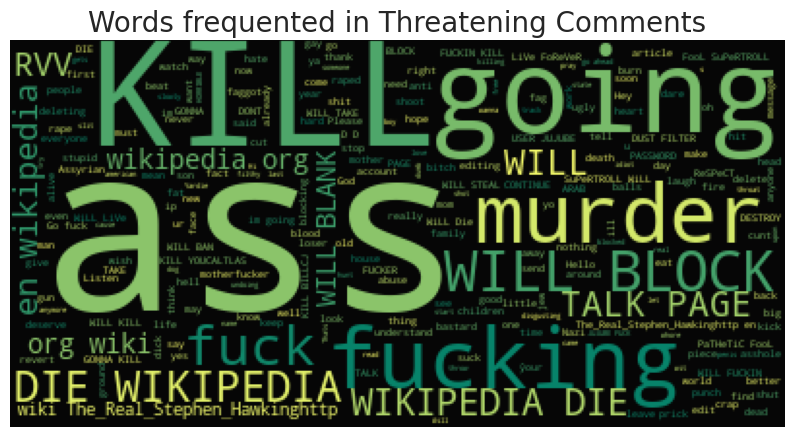

In [24]:
#Threat comments
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
plt.show()

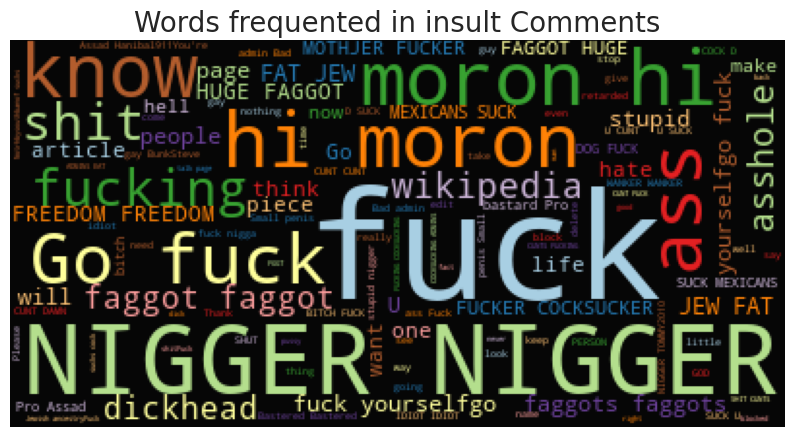

In [25]:
#insult
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
plt.show()

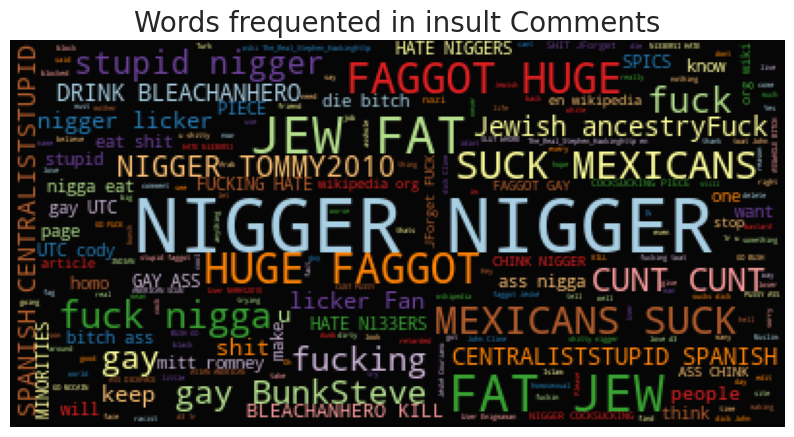

In [26]:
#identity_hate
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
plt.show()

# Topic Modeling

Topic modeling can be a useful tool to summarize the context of a huge corpus(text) by guessing what the "Topic" or the general theme of the sentence.

This can also be used as inputs to our classifier if they can identify patterns or "Topics" that indicate toxicity.

Let's find out!

The steps followed in this kernel:

- Preprocessing (Tokenization using gensim's simple_preprocess)
- Cleaning
- Stop word removal
- Bigram collation
- Lemmatization
- Creation of dictionary (list of all words in the cleaned text)
- Topic modeling using LDA
- Visualization with pyLDAviz

In [34]:
#importing the dataset
data = pd.read_csv("train.csv")

train = data.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = data[~data['id'].isin(list(train['id']))].reset_index(drop=True)

In [35]:
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)

In [36]:
#tokenize the comments
train_text=train.comment_text.apply(lambda x: preprocess(x))
test_text=test.comment_text.apply(lambda x: preprocess(x))
all_text=train_text.append(test_text)

In [37]:
print("Total number of comments:",len(all_text))
print("Before preprocessing:",train.comment_text.iloc[30])
print("After preprocessing:",all_text.iloc[30])

Total number of comments: 159571
Before preprocessing: AC WPWW 

Hi. I don't know if you've seen the conversation at Wikipedia talk:WikiProject Women writers#Authority control. It's a huge project, and really needs to include all writer bios, not just women writers, but sticking with WPWW scope, it would be limited to women's. Probably bot, not AWB, right?
After preprocessing: ['wpww', 'don', 'know', 'you', 'seen', 'the', 'conversation', 'wikipedia', 'talk', 'wikiproject', 'women', 'writers', 'authority', 'control', 'huge', 'project', 'and', 'really', 'needs', 'include', 'all', 'writer', 'bios', 'not', 'just', 'women', 'writers', 'but', 'sticking', 'with', 'wpww', 'scope', 'would', 'limited', 'women', 'probably', 'bot', 'not', 'awb', 'right']


In [38]:
#Phrases help us group together bigrams :  new + york --> new_york
bigram = gensim.models.Phrases(all_text)

In [39]:
bigram[all_text.iloc[30]]

['wpww',
 'don_know',
 'you',
 'seen',
 'the',
 'conversation',
 'wikipedia',
 'talk',
 'wikiproject',
 'women_writers',
 'authority',
 'control',
 'huge',
 'project',
 'and',
 'really',
 'needs',
 'include',
 'all',
 'writer',
 'bios',
 'not',
 'just',
 'women_writers',
 'but',
 'sticking',
 'with',
 'wpww',
 'scope',
 'would',
 'limited',
 'women',
 'probably',
 'bot',
 'not',
 'awb',
 'right']

In [40]:
def clean(word_list):
    """
    Function to clean the pre-processed word lists 
    
    Following transformations will be done
    1) Stop words removal from the nltk stopword list
    2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
    3) Lemmatization (Converting word to its root form)
    """
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]
    #collect bigrams
    clean_words = bigram[clean_words]
    #Lemmatize
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(clean_words)  

In [41]:
#check clean function
print("Before clean:",all_text.iloc[1])
print("After clean:",clean(all_text.iloc[1]))

Before clean: ['carioca', 'rfa', 'thanks', 'for', 'your', 'support', 'request', 'for', 'adminship', 'the', 'final', 'outcome', 'was', 'now', 'administrator', 'you', 'have', 'any', 'comments', 'concerns', 'actions', 'administrator', 'please', 'let', 'know', 'thank', 'you']
After clean: ['carioca', 'rfa_thanks', 'support', 'request', 'adminship', 'final_outcome', 'administrator', 'comment', 'concern', 'action', 'administrator', 'please', 'let_know', 'thank']


In [42]:
#scale it to all text
all_text=all_text.apply(lambda x:clean(x))

In [43]:
#create the dictionary
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")

There are 171254 number of words in the final dictionary


In [44]:
print(dictionary.doc2bow(all_text.iloc[1]))
print("Wordlist from the sentence:",all_text.iloc[1])
#to check
print("Wordlist from the dictionary lookup:", 
      dictionary[21],dictionary[22],dictionary[23],dictionary[24],dictionary[25],dictionary[26],dictionary[27])

[(26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
Wordlist from the sentence: ['carioca', 'rfa_thanks', 'support', 'request', 'adminship', 'final_outcome', 'administrator', 'comment', 'concern', 'action', 'administrator', 'please', 'let_know', 'thank']
Wordlist from the dictionary lookup: teeth use vegetarian want would action administrator


In [45]:
#scale it to all text
corpus = [dictionary.doc2bow(text) for text in all_text]

In [46]:
#create the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)

In [47]:
filename = 'lda_models.sav'
pickle.dump(ldamodel, open(filename, 'wb'))

In [48]:
# load the model from disk
filename = 'lda_models.sav'
ldamodel = pickle.load(open(filename, 'rb'))

In [49]:
pyLDAvis.enable_notebook()

In [50]:
lda_visualization = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_visualization)

In [51]:
lda_visualization_html = pyLDAvis.prepared_data_to_html(lda_visualization)

In [52]:
pyLDAvis.save_html(lda_visualization, fileobj='lda_viz.html')

The above visuals are from the awesome pyLDAviz package which is the python version of R package LDAviz.

The Left side shows the multi-dimensional "word-space" superimposed on two "Principal components" and the relative positions of all the topics.

The size of the circle represents what % of the corpus it contains.

The right side shows the word frequencies within the topic and in the whole corpus.

Clearly, some of the topics show a pattern of toxicity (ie) have a high contribution from toxic words.

# Logistic Regression Model

#### Word Vector Generation

In [107]:
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [ ]:
filename = 'char_vectorizer.pkl'
pickle.dump(char_vectorizer, open(filename, 'wb'))

filename = 'word_vectorizer.pkl'
pickle.dump(word_vectorizer, open(filename, 'wb'))

In [4]:
# load the model from disk
filename = 'char_vectorizer.pkl'
char_vectorizer = pickle.load(open(filename, 'rb'))

filename = 'word_vectorizer.pkl'
word_vectorizer = pickle.load(open(filename, 'rb'))

Modelling a Logistic Regression for each class Label

In [30]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

classifers = dict()

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')
    classifier.fit(train_features, train_target)
    classifers[class_name] = classifier

In [31]:
filename = 'lr_models.sav'
pickle.dump(classifers, open(filename, 'wb'))

In [11]:
# load the model from disk
filename = 'lr_models.sav'
classifers = pickle.load(open(filename, 'rb'))

In [33]:
y_test_toxic = classifers['toxic'].predict(test_features)
y_test_severe_toxic = classifers['severe_toxic'].predict(test_features)
y_test_obscene = classifers['obscene'].predict(test_features)
y_test_threat = classifers['threat'].predict(test_features)
y_test_insult = classifers['insult'].predict(test_features)
y_test_identity_hate = classifers['identity_hate'].predict(test_features)

# Long Short-Term Memory Model

In [17]:
EMBEDDING_FILE='glove.6B.50d.txt'

Set some basic config parameters:

In [18]:
embed_size = 50 
max_features = 20000 
maxlen = 100

In [19]:
data = pd.read_csv("train.csv").fillna(' ')

train = data.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = data[~data['id'].isin(list(train['id']))].reset_index(drop=True)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [7]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random initialization.

In [8]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [9]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [10]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Epoch 1/2
3591/3591 [==============================] - 1428s 396ms/step - loss: 0.0905 - accuracy: 0.8430 - val_loss: 0.0479 - val_accuracy: 0.9941
Epoch 2/2
3591/3591 [==============================] - 1382s 385ms/step - loss: 0.0464 - accuracy: 0.9771 - val_loss: 0.0457 - val_accuracy: 0.9941


In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_model.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# load json and create model
json_file = open('lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)
# load weights into new model
lstm_model.load_weights("lstm_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

32/32 [==============================] - 25s 755ms/step


# XGBoost

In [ ]:
data = pd.read_csv("train.csv").fillna(' ')

train = data.sample(frac=0.8, random_state=42).reset_index(drop=True)
test = data[~data['id'].isin(list(train['id']))].reset_index(drop=True)

In [85]:
# Fucntion to do text preprocessing. This includes tokenizing and stemmimg the text.

nltk.download("punkt")
nltk.download("stopwords")
stop = set(stopwords.words("english"))

ps = PorterStemmer()


def pre_processing_by_nltk(doc, stemming=True, need_sent=False):
    
    # splitting document into sentences
    sentences = sent_tokenize(doc) 

    tokens = []
    for sent in sentences:
        # splitting each sentence into words
        w = word_tokenize(sent)
        #removing punctuations
        words = []
        for word in w:
            if word.strip(string.punctuation) != "":
                words.append(word.strip(string.punctuation))
        # Stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w.lower() for w in tokens if w not in stop]

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
# Getting feature matrix

tfidf = TfidfVectorizer(
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=pre_processing_by_nltk,
    use_idf=True,
    norm="l2",
    smooth_idf=True,
)

y = train['toxic'].values
X = tfidf.fit_transform(train['comment_text'])

In [91]:
#xgb
xgbmodel = xgb.XGBClassifier(max_depth=4, n_estimators=100,learning_rate=0.1, use_label_encoder=False, n_jobs=6, objective="binary:logistic",)
xgbmodel.fit(X, y)

[05:22:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Performance Metrics

### Logistic Regression Accuracy

In [9]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

accuracy_scores = dict()
for class_name in class_names:
    
    clf=classifers[class_name]
    
    y_pred = clf.predict(test_features)
    y_test = test[class_name]

    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores[class_name] = accuracy
    
    print('Accuracy score for class {} is {}'.format(class_name, accuracy))
    

print('Total Accuarcy score is {}'.format(np.mean(accuracy_scores)))

Accuracy score for class toxic is [0.94924017 0.94936392 0.94930125 0.94958325 0.94958325]
Accuracy score for class severe_toxic is [0.99022403 0.99059974 0.99019239 0.99053707 0.99075641]
Accuracy score for class obscene is [0.97327276 0.97245723 0.97320925 0.97280191 0.9727079 ]
Accuracy score for class threat is [0.99699201 0.99702325 0.99702325 0.99699192 0.99699192]
Accuracy score for class insult is [0.96778944 0.96760043 0.96766309 0.96891646 0.96825844]
Accuracy score for class identity_hate is [0.9914147  0.99153976 0.99163377 0.99147709 0.99153976]
Total Accuarcy score is 0.9782228604655181


### LSTM Accuracy

In [117]:
y_pred = lstm_model.predict([X_te], batch_size=1024, verbose=1)
y_test = test[list_classes].values

32/32 [==============================] - 18s 561ms/step


In [119]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
lstm_model.evaluate([X_te], y = test[list_classes].values)

998/998 [==============================] - 31s 30ms/step - loss: 0.4004 - accuracy: 0.9946


[0.4004419445991516, 0.9943912029266357]

In [122]:
t = pd.DataFrame({'Model':['Logistic Regression','LSTM'],'Accuracy':[0.978,0.995]})
t

,Model,Accuracy
0,Logistic Regression,0.978
1,LSTM,0.995


# Prediction on Youtube Comments

In [5]:
us_comments = pd.read_csv('UScomments.csv', error_bad_lines=False)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'


In [8]:
us_comments = us_comments.iloc[0:100,]

### Logistic Regression

In [10]:
test = us_comments['comment_text'].fillna('')

test_word_features = word_vectorizer.transform(test)
test_char_features = char_vectorizer.transform(test)

test_features = hstack([test_char_features, test_word_features])

In [13]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

lr_predictions =[]

for class_name in class_names:
    
    clf=classifers[class_name]
    
    y_pred = clf.predict(test_features)
    
    lr_predictions.append(y_pred)

### LSTM

In [22]:
test = us_comments['comment_text'].fillna('')
list_sentences_test = us_comments["comment_text"].fillna("_na_").values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [23]:
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [34]:
pred = lstm_model.predict([X_te], batch_size=1024, verbose=1)

1/1 [==============================] - 0s 40ms/step


### Example comment predicted by LSTM

In [42]:
index = (pred[9]>0.5)

In [47]:
class_names = np.array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [46]:
print(f'The prediction for " {test[9]} " by the LSTM model is {list(class_names[index])}')

The prediction for " You and your shit brother may have single handedly ruined YouTube.....thanks... " by the LSTM model is ['toxic', 'obscene']
